## Regressione lineare con Pytorch

In questo articolo voglio implementare una regressione lineare con Pytorch.

Iniziamo con l'inquadrare il problema.

Ho N variabili di ingresso $x_1,x_2,\dots,x_N$ ed 1 uscita $y$.<br>
Il modello che voglio usare è quello della regressione lineare così definito:
\begin{equation*}
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_N x_N = \Theta \cdot X^T
\end{equation*}
con:
\begin{equation*}
\Theta =  
\begin{bmatrix}
\theta_0  & \theta_1  & \dots & \theta_N
\end{bmatrix}
\end{equation*}
\begin{equation*}
X =  
\begin{bmatrix}
x_0  & x_1  & \dots & x_N
\end{bmatrix}
\end{equation*}
\begin{equation*}
x_0 = 1
\end{equation*}

Quindi devo trovare i parametri $\theta_0,\theta_1,\dots,\theta_N$ tali che l'errore $loss(y_{modello}, y_{target})$ sia il minimo.

### Il modello lineare

Importiamo i package necessari:

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Definiamo un modello di regressione lineare con 10 ingressi e 1 uscita, ci serviamo della funzione di PyTorch <strong>torch.nn.Linear()</strong>:

In [2]:
model = nn.Linear(10,1)

i cui parametri sono i pesi (weight) e il bias, in tutto 11 parametri da ottimizzare:

In [3]:
model.weight, model.bias

(Parameter containing:
 tensor([[ 0.1788,  0.2042, -0.0414, -0.2970,  0.0262, -0.0625, -0.2426, -0.1951,
           0.3130, -0.0426]], requires_grad=True), Parameter containing:
 tensor([-0.2899], requires_grad=True))

Definendo un tensore di ingresso con dimensioni 1x10

In [4]:
x = torch.randn(1,10)

l'uscita è data semplicemente da:

In [5]:
y = model(x)

Facciamo un controllo degli shape di ingresso e uscita:

In [6]:
print(x.shape)
print(y.shape)

torch.Size([1, 10])
torch.Size([1, 1])


Otteniamo quanto atteso, un ingresso 1x10 e un'uscita 1x1 (uno scalare).

Ancora una volta voglio verificare che il modelllo di PyTorch faccia quanto atteso, ovvero l'operazione $w \cdot x^T+b$<br>
Definisco un tensore $x$ 1x10 di float

In [7]:
x = torch.tensor([1,23,4,5,6,77,8,9,12,22], dtype=torch.float).view([1,10])
x.shape

torch.Size([1, 10])

L'uscita del modello è:

In [8]:
y1 = model(x)
y1

tensor([[-2.5974]], grad_fn=<AddmmBackward>)

Verifichiamo che il  calcolo $w \cdot x^T+b$ sia giusto. Per fare il prodotto scalare tra i due vettori si usa l'operatore <strong>torch.mm</strong><br>
Inoltre occorre che i due tensori di torch.mm siano il primo un vettore riga il secondo un vettore colonna. <br>
Il tensore dei pesi è un tensore riga 1x10:

In [9]:
w = model.weight
w.shape

torch.Size([1, 10])

Poiché x è originariamente un vettore riga 1x10, lo trasformo in un vettore colonna 10x1 usando la funzione <strong>.view()</strong>. In questo caso x.view(10,1). <br>Per fare la cosa più generica posso usare x.view(-1,1). Pytorch capisce che è il secondo argomento (1) della funzione che conta e regola il primo di conseguenza.

In [10]:
y2 = torch.mm(w, x.view(-1,1)) + model.bias # w*x+b
y2

tensor([[-2.5974]], grad_fn=<AddBackward0>)

Il risultato è quello atteso: y1=y2<br>
Il modello <strong>torch.nn.Linear</strong> calcola la combinazione lineare degli ingressi come ci attendevamo.

### Modello lineare, ingresso singolo e training del modello

Facciamo il primo esempio più semplice con un solo ingresso e una sola uscita.

Creiamo un set di dati, costituito da N coppie (x,y), che stanno in una relazione "abbastanza" lineare tra di loro.<br>
Per fare questo definiamo una relazione lineare tra y e x. E aggiungiamo un rumore per rendere la cosa più realistica.

In [11]:
x_samples = torch.linspace(0, 100, steps=101).view(-1,1) #l'ingresso deve essere in formato colonna
m = 13.5 #coefficiente angolare
b = 12 #ordinata all'origine
y_samples_lineare = m * x_samples + b  

In [12]:
y_samples_lineare.size()

torch.Size([101, 1])

In [13]:
y_samples_noise = 200 * torch.randn(x_samples.shape[0], 1) #genera un vettore colonna di dati random, con media 0 e varianza 5 
y_samples_noise.size()

torch.Size([101, 1])

Abbiamo già visto che i vettori y_samples_lineare e y_samples_noise hanno le stesse dimensioni. Possiamo pertanto sommarli:

In [14]:
y_samples = y_samples_lineare + y_samples_noise

(x_samples, y_samples) è il dataset di punti che devo interpolare (o fittare).

Instanzio il modello lineare con un ingresso e una uscita. Il parametro bias=True indica che devo ottimizare il bias (ordinata all'origine) del modello.

In [15]:
model1 = torch.nn.Linear(1,1, bias=True) 

Il modello ha solo due parametri da ottimizzare, che in accordo alla letteratura classica chiameremo $m$ e $q$:

In [16]:
model1.weight, model1.bias

(Parameter containing:
 tensor([[-0.6860]], requires_grad=True), Parameter containing:
 tensor([0.4710], requires_grad=True))

Calcolo le uscite del modello lineare appena definito:

In [17]:
y_linmod = model1(x_samples)
y_linmod.size()

torch.Size([101, 1])

Mettiamo su grafico le due curve (x_samples, y_samples) e (x_samples, y_linmod).<br>
Come si vede il modello lineare non è stato adattato. Pertanto la linea rossa devia nettamente dalla nuvola di punti blu.

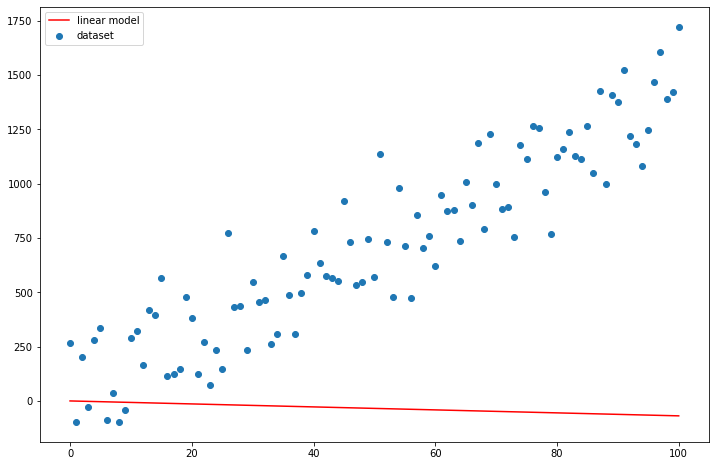

In [18]:
ax = plt.figure(figsize = (12,8))
plt.scatter(x_samples.numpy(),y_samples.numpy(), label="dataset")
plt.plot(x_samples.numpy(),y_linmod.detach().numpy(),'r', label="linear model")
plt.legend()
plt.show()

Calcolo l'errore quadratico medio tra il dataset e il valore corrente dell'uscita. Per qualche motivo la funzione predefinita di PyTorch <strong>nn.MSELoss()</strong> mi da errore, pertanto definisco l'errore quadratico medio esplicitamente.

In [19]:
# errore = nn.MSELoss(y_linmod, y_linmod)
errore = torch.mean(torch.pow(y_samples-y_linmod, 2))
errore

tensor(763498.5625, grad_fn=<MeanBackward1>)

Calcolo le derivate parziali dell'errore rispetto ai due parametri m e q, usando la funzione backward().

In [20]:
errore.backward()

Come ottimizzatore uso lo SGD (Stochastic Gradient Descent):

In [21]:
optimizer = torch.optim.SGD(model1.parameters(),1e-4)

Itero su un numero basso di iterazioni, poiché la convergenza è veloce.

tensor(763498.5625, grad_fn=<MeanBackward1>)


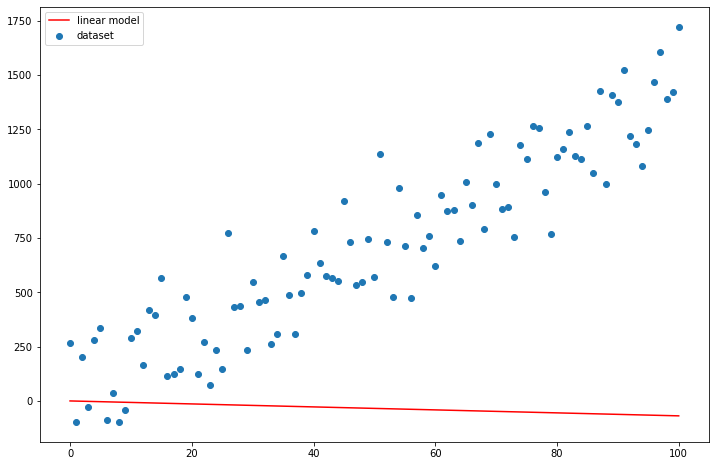

tensor(113893.5156, grad_fn=<MeanBackward1>)


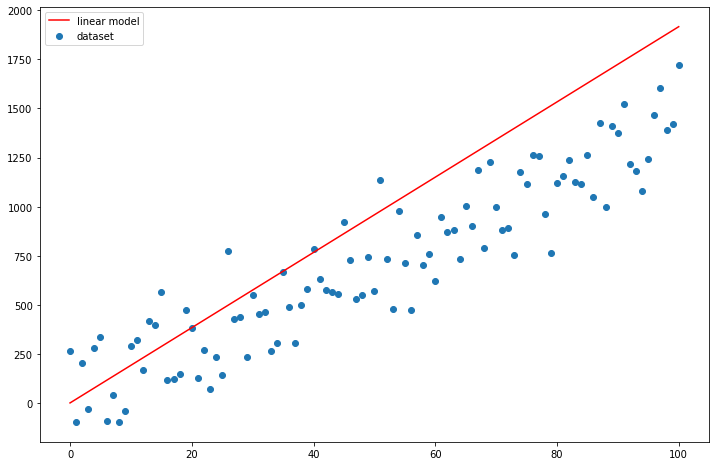

tensor(38071.4688, grad_fn=<MeanBackward1>)


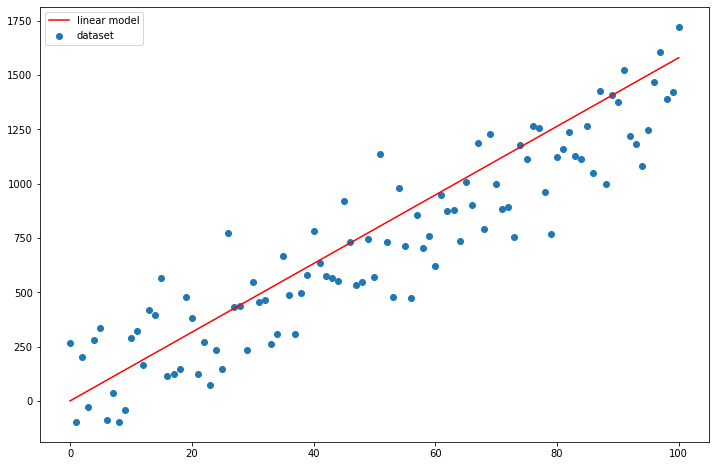

tensor(29821.9082, grad_fn=<MeanBackward1>)


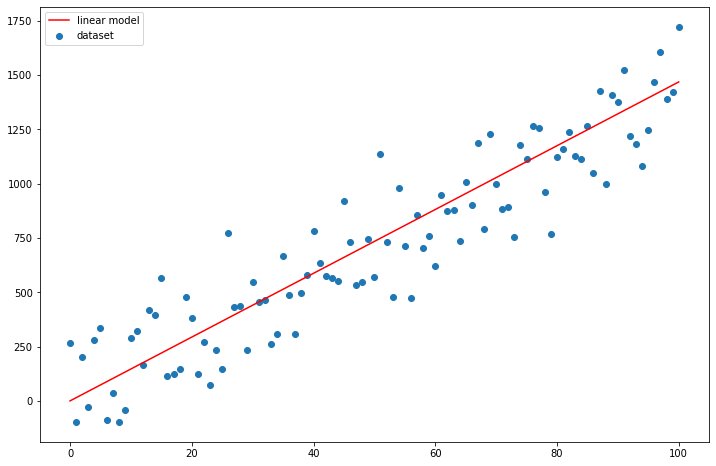

tensor(28924.3320, grad_fn=<MeanBackward1>)


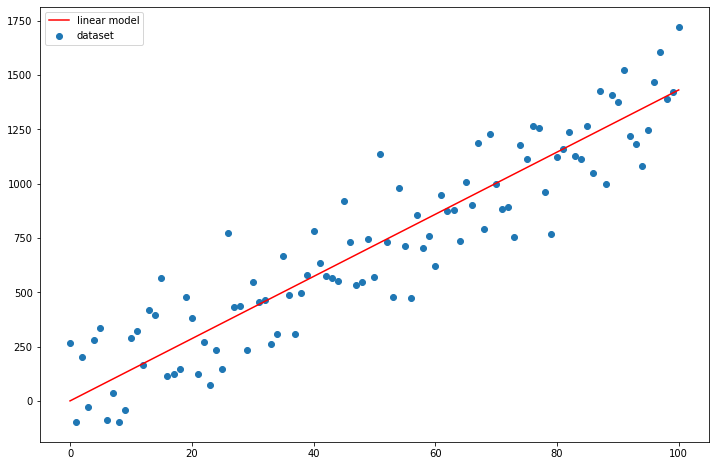

In [22]:
for i in range(5):
    y_linmod = model1(x_samples)
    errore = torch.mean(torch.pow(y_samples-y_linmod, 2))
    errore.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(errore)
    ax = plt.figure(figsize = (12,8))
    plt.scatter(x_samples.numpy(),y_samples.numpy(), label="dataset")
    plt.plot(x_samples.numpy(),y_linmod.detach().numpy(),'r', label="linear model")
    plt.legend()
    plt.show()

Come si vede dai grafici sopra la convergenza è velocissima, già alla seconda iterazione la linea rossa si attesta sulla nuvola blu.<br>
Un altro paio di iterazioni e il fitting è ottimale.

I parametri ottimizzati sono:

In [23]:
list(model1.parameters())

[Parameter containing:
 tensor([[14.1793]], requires_grad=True), Parameter containing:
 tensor([0.6987], requires_grad=True)]

Come si vede il model.weight è molto vicino al valore di $m = 13.5$ che avevamo usato per generare il dataset.<br>
Il valore di q invece si discosta abbastanza, 12 contro -0.2154<br>
Qualche <strong>ipotesi</strong> sul perché di questa discrepanza?

### Modello di regressione lineare multidimensionale

Facciamo un esempio con più variabili di ingresso. 4 ingressi per essere precisi.
Questi sono gli step:
- genero un dataset
- creo il modello di regressione lineare
- definisco una funzione errore e un ottimizzatore
- faccio il training del modello

#### Genero un dataset

Creo un dataset di 1000 punti $(x_1,x_2,x_3,x_4,y)$. <br>
Per i dati di ingresso uso la funzione torch.linspace. <br>
I dati di uscita sono una combinazione lineare degli ingressi, i coefficienti $m_i$ sono stati scelti in modo che ogni ingresso contribuisca sull'uscita.   

In [24]:
#x1 = torch.linspace(0,100,100).view(-1,1)
#x2 = torch.linspace(-1,1,100).view(-1,1)
#x3 = torch.linspace(-10,0,100).view(-1,1)
#x4 = torch.linspace(75,150,100).view(-1,1)
x1 = np.linspace(0,100,50)
x2 = np.linspace(-1,1,50)
x3 = np.linspace(-10,0,50)
x4 = np.linspace(75,150,50)

m1, m2, m3, m4 = 0.5, 25, 50, -0.66 #coeff angolare per ogni direzione
M = torch.tensor([m1,m2,m3,m4]).view([-1,1]) #combino i coeff angolari in un vettore colonna

# X = torch.from_numpy(x_comb).type(torch.float) # setto float altrimenti si setta automaticamente double e da errore


# y_samples = m1 * x1 + m2 * x2 + m3 * x3 + m4 * x4 
# y_samples = torch.from_numpy(y_samples).type(torch.float)

Genero uno spazio a 4 dimensioni, usando le coordinate x1,x2,x3,x4:

In [25]:
x_comb = np.array([[x1[i],x2[j],x3[l],x4[m]] 
      for i in range(x1.shape[0]) 
      for j in range(x2.shape[0]) 
      for l in range(x3.shape[0]) 
      for m in range(x4.shape[0])])

x_comb.shape

(6250000, 4)

In [26]:
x_comb

array([[  0.        ,  -1.        , -10.        ,  75.        ],
       [  0.        ,  -1.        , -10.        ,  76.53061224],
       [  0.        ,  -1.        , -10.        ,  78.06122449],
       ...,
       [100.        ,   1.        ,   0.        , 146.93877551],
       [100.        ,   1.        ,   0.        , 148.46938776],
       [100.        ,   1.        ,   0.        , 150.        ]])

Converto x_comb in un tensore e setto il tipo su flot(=float32), poichè il tipo double(=float64) genera un errore: 

In [27]:
X = torch.from_numpy(x_comb).type(torch.float)

Calcolo l'uscita del modello lineare:

In [28]:
y_samples = torch.mm(X,M)
y_samples.shape

torch.Size([6250000, 1])

Così ho completato la geneerazione del set di dati (x_samples, y_samples)

#### Creazione modello Lineare

Definiamo il modello:

In [29]:
model2 = torch.nn.Linear(4,1)

Questi sono i parametri, inizializzati in maniera random:

In [30]:
model2.weight, model2.bias

(Parameter containing:
 tensor([[ 0.4048,  0.0537, -0.0676, -0.4787]], requires_grad=True),
 Parameter containing:
 tensor([0.3090], requires_grad=True))

Concateniamo i tensori unidimensionali di ingresso per avere un tensore 1000x4 da usare come ingresso del modello.<br> 
Usiamo <strong>torch.cat</strong>, il secondo parametro fornito indicato che lo stack deve essere fatto mettendo i vettori colonna uno accanto all'altro )

In [31]:
# x1 = torch.linspace(0,100,100).view(-1,1)
# x2 = torch.linspace(-1,1,100).view(-1,1)
# x3 = torch.linspace(-10,0,100).view(-1,1)
# x4 = torch.linspace(75,150,100).view(-1,1)

In [32]:
# X = torch.cat((x1,x2,x3,x4),1)
#X = torch.from_numpy(x_comb).type(torch.float) # setto float altrimenti si setta automaticamente double e da errore
#X.shape

Verifichiamo il tipo dei dati:

In [33]:
X.type()

'torch.FloatTensor'

Calcolo l'uscita del modello lineare, e verifico che lo shape dell'uscita si giusta.<br>
1000 punti di ingresso, ne generano altrettanti in uscita, pertanto è corretto.

In [34]:
y_linmod = model2(X)
y_linmod.shape

torch.Size([6250000, 1])

L'errore quadratico medio è:

In [35]:
errore = torch.mean(torch.pow(y_samples-y_linmod,2))
errore

tensor(92888.2188, grad_fn=<MeanBackward1>)

Plottiamo le uscite generate e confrontiamole con quelle del dataset.<br>
Sull'asse x metto l'ordinale del punto.

In [36]:
asse_x = np.linspace(0, X.shape[0]-1, num=X.shape[0])

In [37]:
def downsample_4_plot(asse_x, downsample_factor):
    asse_x_dwnsmpl = asse_x[0:-1:downsample_factor]
    return asse_x_dwnsmpl

In [38]:
downsample_factor = 25000
asse_x_dwnsmpl = downsample_4_plot(asse_x,downsample_factor)
y_samples_dwnsmpl = downsample_4_plot(y_samples, downsample_factor)
y_linmod_dwnsmpl = downsample_4_plot(y_linmod, downsample_factor)
asse_x_dwnsmpl.shape

(250,)

In [39]:
y_linmod_dwnsmpl = downsample_4_plot(y_linmod, downsample_factor)
y_linmod_dwnsmpl.shape

torch.Size([250, 1])

In [40]:
asse_x.shape, X.shape, y_samples.shape, y_linmod.shape

((6250000,),
 torch.Size([6250000, 4]),
 torch.Size([6250000, 1]),
 torch.Size([6250000, 1]))

In [41]:
asse_x[0:-1:downsample_factor].shape

(250,)

In [42]:
downsample_factor

25000

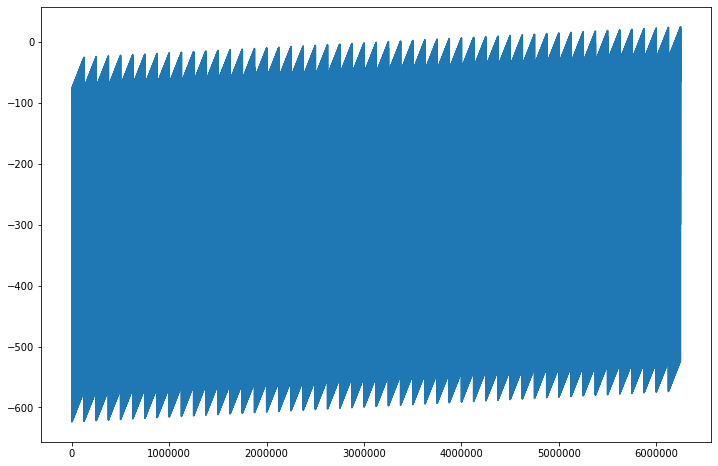

In [43]:
ax = plt.figure(figsize = (12,8))
plt.plot(asse_x,y_samples.detach().numpy())
plt.show()

In [44]:
y_samples.numpy()[0:200000:downsample_factor]

array([[-574.5    ],
       [-564.2959 ],
       [-554.09186],
       [-543.88776],
       [-533.6837 ],
       [-573.4796 ],
       [-563.2755 ],
       [-553.0715 ]], dtype=float32)

In [45]:
y_linmod.detach().numpy()[0:-1:downsample_factor].shape

(250, 1)

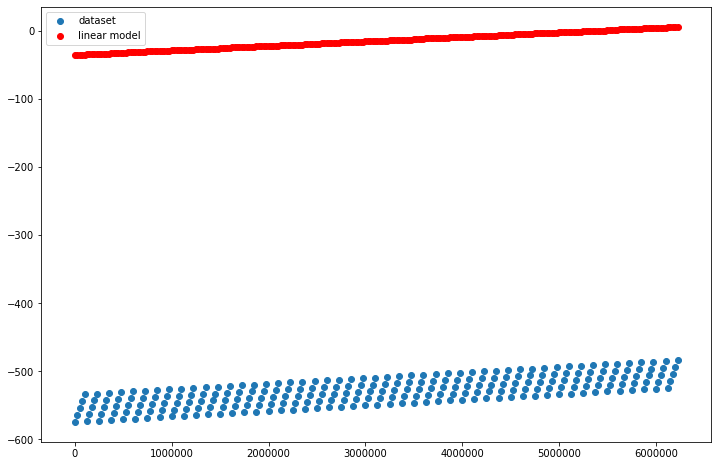

In [46]:
ax = plt.figure(figsize = (12,8))
plt.scatter(asse_x[0:-1:downsample_factor],y_samples.numpy()[0:-1:downsample_factor], label="dataset")
plt.scatter(asse_x[0:-1:downsample_factor],y_linmod.detach().numpy()[0:-1:downsample_factor],c='r', label="linear model")
plt.legend()
plt.show()

Definiamo il SGD come ottimizzatore, indichiamo che i parametri di ottimizzazione sono quelli di model2, e gli diamo un passo di apprendimento abbastanza piccolo da essere sicuri che converga, ma senza essere troppo lenti, dopo qualche iterazione sono arrivato a 5e-5:

In [47]:
model2 = torch.nn.Linear(4,1) #ridefinisco il modello per azzerare i calcoli precedenti
optimizer = torch.optim.SGD(model2.parameters(), 5e-5)

Adesso sono pronto ad eseguire il training del modello.<br>
I passi sono i soliti:<br>
-calcolo dell'uscita<br>
-calcolo dell'errore<br>
-calcolo del gradiente (errore.backward)<br>
-aggionamento dei parametri (optimizer.step)<br>
-reset del gradiente (optimizer.zero_grad)

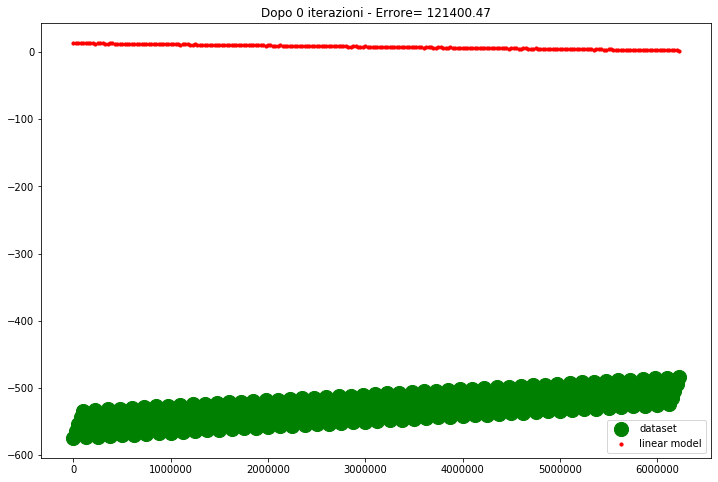

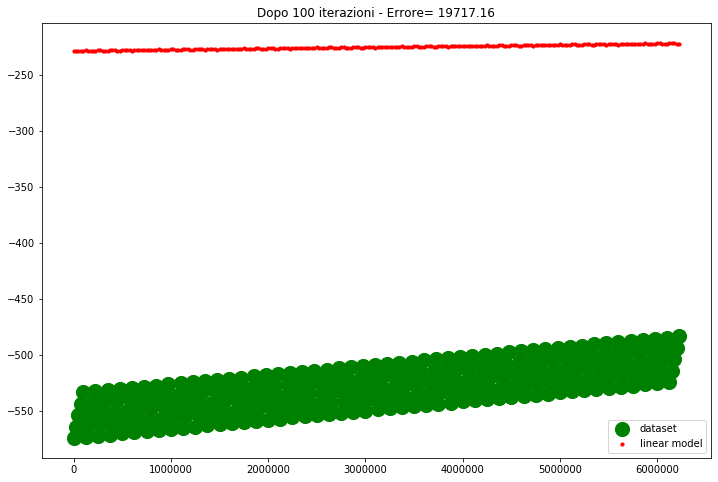

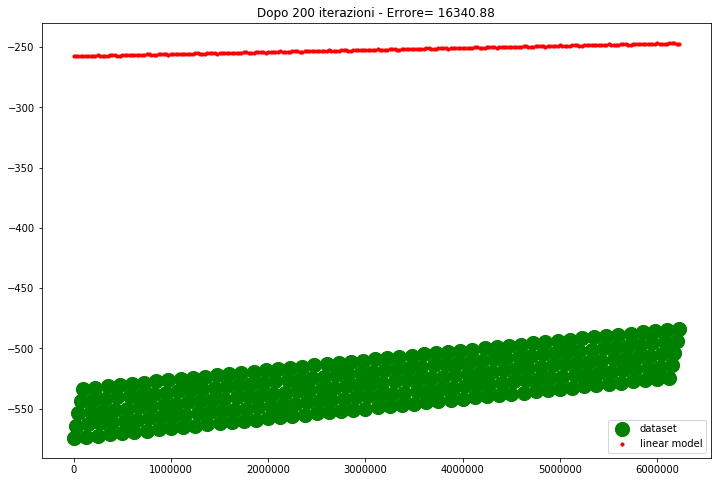

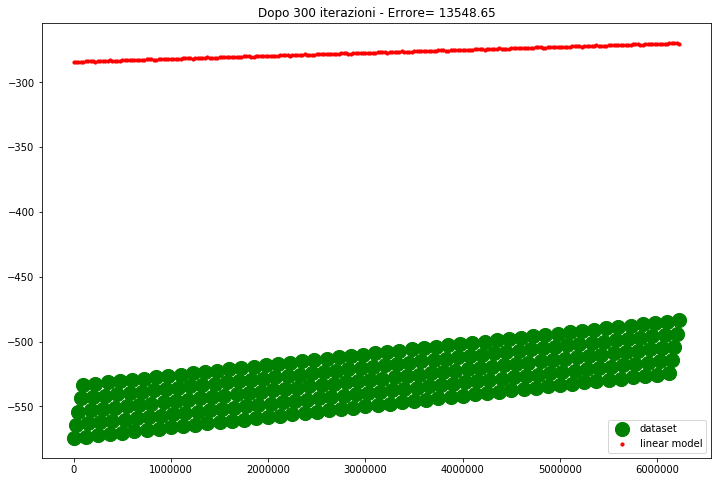

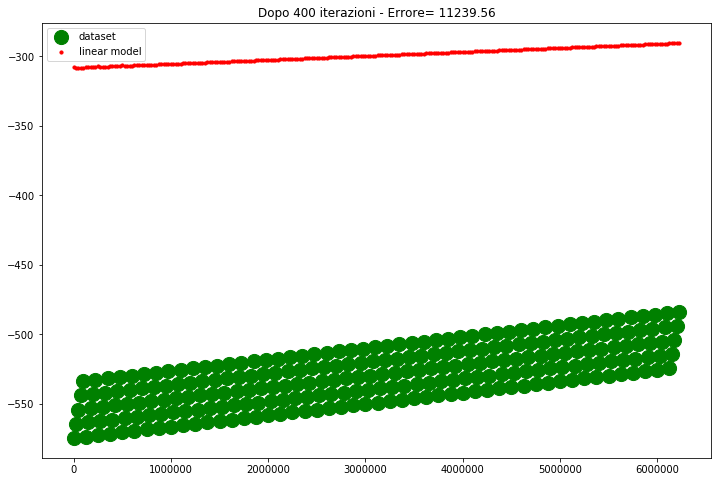

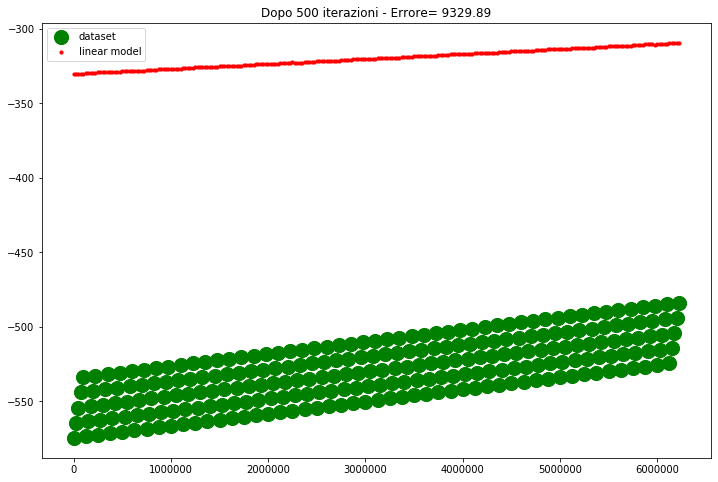

In [48]:
for itr in range(501):
    y_linmod = model2(X)   #calcolo l'uscita con il modello corrente
    errore = torch.mean(torch.pow(y_samples-y_linmod,2)) #calcolo l'errore tra l'uscita desiderata e l'uscita corrente
    errore.backward()      #applico la funzione backward, le derivate parziali dell'errore vengono calcolate rispetto alle variabili per cui è definito required_grad=True
    optimizer.step()       #aggiornamento dei parametri da ottimizzare usando le derivate calcolate nel passo precedente
    optimizer.zero_grad()  #azzero i gradienti
    if ((itr==0) or (itr==100) or (itr==200) or (itr==300) or (itr==400) or (itr==500)) : #genera il grafico agli step fissati 
        ax = plt.figure(figsize = (12,8))
        plt.scatter(downsample_4_plot(asse_x,downsample_factor),
                    downsample_4_plot(y_samples, downsample_factor).numpy(),
                    label="dataset", c='g', s=200)
        plt.scatter(downsample_4_plot(asse_x,downsample_factor),
                    downsample_4_plot(y_linmod, downsample_factor).detach().numpy().reshape(1,-1),
                    c='r', label="linear model",s=10)
        plt.legend()
        plt.title('Dopo %d iterazioni - Errore= %1.2f' %(itr,errore))
        plt.show()

Come si vede dopo 500 iterazioni l'errore è abbastanza alto e la convergenza abbastanza lenta.<br>

Se provo ad alzare il learning rate, l'errore inizia a divergere, per cui non è una strada praticabile.<br>
La domanda che mi pongo è: come mai con un learning rate così basso (5e-5) la convergenza è così critica che basta alzare il learning rate di poco (per esempio 1e-4) perché la convergenga sia compromessa.<br>
La risposta che riesco a darmi è che gli ordini di grandezza delle variabili d'ingresso sono diversi, per cui lo spostamento del punto (dipendente dal learning rate e dal gradiente) deve essere compatibile con tutte le variabili, pertanto deve essere piccolo.<br>
Vediamo se riesco a velocizzare la convergenza <strong>normalizzando</strong> le variabili $x_1, x_2, x_3, x_4$.

Normalizziamo le coordinate.

In [49]:
X.shape

torch.Size([6250000, 4])

In [50]:
m[0]

TypeError: 'float' object is not subscriptable

In [ ]:
m = X.min(dim=0)               #valore minimo per ogni colonna di X
M = X.max(dim=0)               #valore massimo per ogni colonna
u = (M[0]+m[0])/2              #valor medio per ogni colonna
d = (M[0]-m[0]).view([1,-1])   #intervallo min-max, per ogni colonna

m = X.min(dim=0)                     #valore minimo per ogni colonna di X
M = X.max(dim=0)                     #valore massimo per ogni colonna
u = (M.values+m.values)/2            #valor medio per ogni colonna
d = (M.values-m.values).view([1,-1]) #intervallo min-max, per ogni colonna

Ad ogni coordinata sottraggo il suo valor medio e divido per l'intervallo di variazione:

\begin{equation*}
\hat{x_i} =  \frac {x_i - u}{d} \hspace{1cm} \forall i=1,2,3,4
\end{equation*}

Il nuovo set di coordinate è $\hat{x_1},\hat{x_2},\hat{x_3},\hat{x_4}$.<br>
Per fare questo calcolo uso <strong>torch.mul</strong> che realizza una moltiplicazione elemento-per-elemento tra i due operatori. Es.:

\begin{equation}
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
a_{31} & a_{32}
\end{bmatrix}
\begin{bmatrix}
b_1 \\
b_2
\end{bmatrix}
=
\begin{bmatrix}
a_{11}*b_1 & a_{12}*b_2 \\
a_{21}*b_1 & a_{22}*b_2 \\
a_{31}*b_1 & a_{32}*b_2
\end{bmatrix}
\end{equation}

In [ ]:
X_norm = torch.mul((X-u),1/d)

Azzero il modello e ridefinisco l'ottimizzatore con un learning rate di 0.1

In [ ]:
model2 = torch.nn.Linear(4,1) #ridefinisco il modello per azzerare i calcoli precedenti
optimizer = torch.optim.SGD(model2.parameters(), 0.1)

Copio il codice di prima per fare il training del modello, cambio solo l'ingresso, stavolta userò X_norm invece di X.

In [ ]:
for itr in range(501):
    y_linmod = model2(X_norm)   #calcolo l'uscita con il modello corrente
    errore = torch.mean(torch.pow(y_samples-y_linmod,2)) #calcolo l'errore tra l'uscita desiderata e l'uscita corrente
    errore.backward()      #applico la funzione backward, le derivate parziali dell'errore vengono calcolate rispetto alle variabili per cui è definito required_grad=True
    optimizer.step()       #aggiornamento dei parametri da ottimizzare usando le derivate calcolate nel passo precedente
    optimizer.zero_grad()  #azzero i gradienti
    if ((itr==0) or (itr==100) or (itr==200) or (itr==300) or (itr==400) or (itr==500)) : #genera il grafico agli step fissati 
        ax = plt.figure(figsize = (12,8))
        plt.scatter(downsample_4_plot(asse_x,downsample_factor),
                    downsample_4_plot(y_samples, downsample_factor).numpy(),
                    label="dataset", c='g', s=200)
        plt.scatter(downsample_4_plot(asse_x,downsample_factor),
                    downsample_4_plot(y_linmod, downsample_factor).detach().numpy().reshape(1,-1),
                    c='r', label="linear model",s=10)
        plt.legend()
        plt.title('Dopo %d iterazioni - Errore= %1.2f' %(itr,errore))
        plt.show()

Sull'asse y abbiamo i valori di uscita, sull'asse x abbiamo l'ordinale del punto (e non la variabile di ingresso, poichè era impossibile riprodurre i 4 ingressi su grafico).<br>
Per come sono fatti i dati, 4 assi ridotti ad un ordinale, sembra che ci siano 5 linee diverse in realta è un artefatto, dovuto al fatto he mi sto ostinando a rappresentare una cosa che non dovrei.<br>
I valori desiderati li ho rappresentati con un marker molto spesso in modo che la posizione relativa tra le due curve sia ben visibile specialmente nel caso in cui sono vicine o sovrapposte.<br>
Come si vede alla 300esima iterazione i due modelli lineare iniziano a sovrapporsi. Alla 500esima iterazione sono praticamente sovrapposti e l'errore è nullo (o molto basso).

Il training ci ha consegnato questi valori dei parametri ottimizzati:

In [ ]:
model2.weight, model2.bias

I coefficienti angolari così ottenuti devono essere denormalizzati per tornare allo spazio $\mathbb{R}^4$ originale.<br>
Per farlo divido ciascuna coordinata per il delta $d$ che avevo calcolato qualche step sopra.

Anche in questo caso faccio una moltiplicazione elemento-per-elemento con <strong>torch.mul</strong>

In [ ]:
torch.mul(model2.weight,1/d)

Facciamo un confronto con i valori usati per generare il dataset:<br>
m1 = 0.5 vs 0.4999<br>
m2 = 25 vs 24.9961<br>
m3 = 50 vs 49.9919<br>
m4 = -0.66 vs -0.6599<br>
Come si vede i valori trovati sono praticamente perfetti

Usando i parametri ottimizzati calcolo l'uscita e l'errore: 

In [ ]:
y_linmod = model2(X_norm)
errore = torch.mean(torch.pow(y_samples-y_linmod,2))
errore

Come atteso l'errore è molto basso.